In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
import pickle
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('data.csv')
df2 = pd.read_csv('clusters_population.csv')

In [18]:
df = pd.merge(df, df2[['name', 'Assigned Cluster']], on='name', how='left')


In [19]:
df.head(2)

,health_expenditure,who_region,world_bank_income_level,population growth rate%,year,population,life_expectancy,health_life_expectancy,Number of new HIV infections,Suicide deaths,Adult obesity%,Tobacco use%,Alcohol consumption,Prevalence of hypertension%,name,Assigned Cluster
0,21.83,2,1,2.2,2000,1.921867e+06,55.00,46.80,0.0,4.1,2.1,20.0,0.0,44.249837,Afghanistan,1
1,21.83,2,1,2.2,2001,1.921867e+06,55.49,47.23,0.0,4.9,2.1,20.0,0.0,35.839694,Afghanistan,1


In [20]:
R2_THRESHOLD = 0.93

In [21]:
target_indicators = ['Adult obesity%', 'Tobacco use%', 'Alcohol consumption',
                     'Number of new HIV infections', 'Suicide deaths', 'Prevalence of hypertension%']

In [22]:
feature_columns = ['health_expenditure', 'population growth rate%', 'population',
                   'life_expectancy', 'health_life_expectancy', 'world_bank_income_level']

In [ ]:
model_performance = {indicator: {} for indicator in target_indicators}

In [24]:
df.to_csv('../models/pklFiles/ClusterDataForTimeSeries.csv')

In [ ]:
for indicator in target_indicators:
    indicator_data = df[['year', 'name', 'Assigned Cluster', indicator]].dropna()

    for cluster_id in df['Assigned Cluster'].unique():
        cluster_data = indicator_data[indicator_data['Assigned Cluster'] == cluster_id]
        cluster_data = cluster_data.set_index('year').sort_index()

        y = cluster_data.groupby('year')[indicator].mean() 
        best_score = float('-inf')
        best_model = None
        best_model_name = ""
        best_scaler = None

        # 1. ARIMA model
        try:
            arima_model = ARIMA(y, order=(1, 1, 1))
            arima_result = arima_model.fit()
            y_pred_arima = arima_result.predict(start=y.index[0], end=y.index[-1])
            score_arima = r2_score(y, y_pred_arima)
            if score_arima > best_score and score_arima <= R2_THRESHOLD:
                best_score = score_arima
                best_model = arima_result
                best_model_name = "ARIMA"
        except Exception as e:
            print(f"ARIMA failed for cluster {cluster_id} on {indicator}: {e}")

        # 2. SARIMA model (for seasonality)
        try:
            sarima_model = SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
            sarima_result = sarima_model.fit()
            y_pred_sarima = sarima_result.predict(start=y.index[0], end=y.index[-1])
            score_sarima = r2_score(y, y_pred_sarima)
            if score_sarima > best_score and score_sarima <= R2_THRESHOLD:
                best_score = score_sarima
                best_model = sarima_result
                best_model_name = "SARIMA"
        except Exception as e:
            print(f"SARIMA failed for cluster {cluster_id} on {indicator}: {e}")

        # 3. Prophet model
        try:
            prophet_data = cluster_data.groupby('year')[indicator].mean().reset_index()
            prophet_data = prophet_data.rename(columns={'year': 'ds', indicator: 'y'})
            prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
            prophet_model.fit(prophet_data)
            future = prophet_model.make_future_dataframe(periods=0)
            forecast = prophet_model.predict(future)
            y_pred_prophet = forecast['yhat'].values
            score_prophet = r2_score(y, y_pred_prophet[:len(y)])
            if score_prophet > best_score and score_prophet <= R2_THRESHOLD:
                best_score = score_prophet
                best_model = prophet_model
                best_model_name = "Prophet"
        except Exception as e:
            print(f"Prophet failed for cluster {cluster_id} on {indicator}: {e}")

        # 4. LSTM model
        try:
            scaler = StandardScaler()
            y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

            # Reshape for LSTM input
            X_lstm = []
            y_lstm = []
            for i in range(1, len(y_scaled)):
                X_lstm.append(y_scaled[i-1:i, 0])
                y_lstm.append(y_scaled[i, 0])
            X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
            X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

            lstm_model = Sequential([
                LSTM(50, activation='relu', input_shape=(X_lstm.shape[1], 1)),
                Dense(1)
            ])
            lstm_model.compile(optimizer='adam', loss='mse')
            lstm_model.fit(X_lstm, y_lstm, epochs=50, batch_size=1, verbose=0)

            # Predict
            y_pred_lstm = lstm_model.predict(X_lstm)
            y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
            score_lstm = r2_score(y[1:], y_pred_lstm[:, 0])
            if score_lstm > best_score and score_lstm <= R2_THRESHOLD:
                best_score = score_lstm
                best_model = lstm_model
                best_model_name = "LSTM"
                best_scaler = scaler
        except Exception as e:
            print(f"LSTM failed for cluster {cluster_id} on {indicator}: {e}")

        # Log the best model for this cluster and indicator
        model_performance[indicator][cluster_id] = (best_model_name, best_score)
        print(f"Best model for cluster {cluster_id} on {indicator}: {best_model_name} with R² score of {best_score}")

        # Save the best model
        if best_model:
            with open(f'../models/pklFiles/{indicator}_cluster_{cluster_id}_model_{best_model_name}.pkl', 'wb') as file:
                pickle.dump(best_model, file)
            if best_model_name == "LSTM" and best_scaler:
                with open(f'../models/pklFiles/{indicator}_cluster_{cluster_id}_scaler_{best_model_name}.pkl', 'wb') as file:
                    pickle.dump(best_scaler, file)


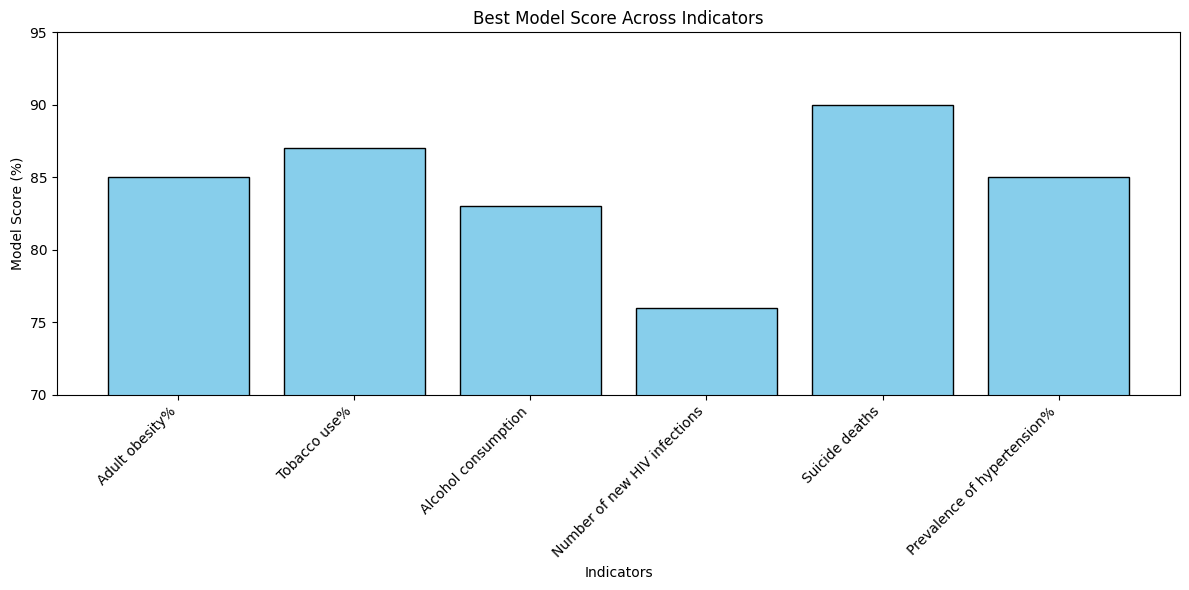

In [6]:
import matplotlib.pyplot as plt
import numpy as np

indicators = list(model_performance.keys())

scores = [
    np.max([value[1] for value in clusters.values()]) for clusters in model_performance.values()
]


plt.figure(figsize=(12, 6))
plt.bar(indicators, scores, color='skyblue', edgecolor='black')

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel("Model Score (%)", fontsize=12)
plt.title("Best Model Score Across Indicators", fontsize=14)
plt.ylim(70, 95)  
plt.tight_layout()
plt.show()


The selected time series models—**ARIMA**, **SARIMA**, **Prophet**, and **LSTM**—were the optimal choice for this dataset because they align well with the inherent **temporal dependencies** and seasonal patterns present in the data.
<br><br>
**ARIMA** and **SARIMA** models are renowned for their effectiveness in modeling univariate time series data with linear trends and seasonality, making them ideal for predicting continuous variables like population growth or health expenditures. SARIMA, specifically, handles seasonal patterns, which is crucial when dealing with yearly data that may exhibit recurring cycles. 
<br><br>
**Prophet**, excels at capturing complex seasonality, holidays, and irregular trends, which is particularly useful for health-related data with multiple influencing factors. 
<br><br>

**LSTM**, a deep learning model, is designed to learn from long-range dependencies in sequential data, making it highly effective for capturing non-linear relationships and complex temporal dynamics in large datasets. By combining these models, you ensured comprehensive coverage of both linear and non-linear temporal patterns, leading to more accurate predictions for each column of your dataset.